In [1]:
import numpy as np
import matplotlib.pyplot as plt
from scipy.integrate import odeint
import astropy.constants as const
import astropy.units as un
from astropy.visualization import quantity_support
import scipy as sp
from scipy.special import kv

In [2]:
#creating the grid x = r/r_lc
N_position = 500
x1 = 1.01
x2 = 5.

X = np.linspace(x1, x2, N_position)*un.dimensionless_unscaled

X_reversed = X[::-1] #reversed matrix for the electron integration



In [3]:
# Values and units of physical constants and other quantities and parameters that are used through the code

e = const.e.esu       #Electron charge
m_e = const.m_e.cgs   #Electron mass
c = const.c.cgs       #Speed of light
h = const.h.cgs       #Planck's constant

r_surface = 10**6 * un.cm  #Surface of the NS
B_surface = 10**13 * un.G  #Magnetic field at the surface of the NS
Period = 0.033 * un.s      #Period of rotation

r_lc = c*Period/(2*np.pi)  #Light cylinder radius
B_lc = B_surface*r_surface**3/r_lc**3   #Magnetic field at the light cylinder

R_curv = X**2*r_lc   #Radius of curvature of the particle trajectories, calculated analyticaly

#Value of Lorentz factor when the radiation reaction limit is reached
gamma_rrl = (3*r_lc**2*B_lc/(2*e))**(1/4) / (r_lc.unit**2*B_lc.unit/e.unit)**(1/4)
# gamma_rrl = 4*10**7*(B_surface/(10**13*un.G))**(1/4)*(Period/(1*un.s))**(-1/4)   

v_r = c*np.sqrt(X**2 - 1)**0.5/X    #radial speed as function of radial distance
v_phi = c/X                         #azimuthial speed as function of radial distance

k = 2.   #Pair multiplicity

In [4]:
#Analytical expressions of fields and velocities as a function of the radial distance x

#radial speed 
def v_r(X):
    
    """
    input: X (radial distance)
    output: v_r (radial speed)
    The radial speed in cgs units as a function of the dimensionless radial distance X 
    as given in Contopoulos, Petri, Stefanou 2019
    """
    
    v_r = c*np.sqrt(X**2 - 1)**0.5/X    
    
    return v_r 
    


v_phi = c/X                         #azimuthial speed 

#vertical magnetic field
def B_z(X):
    
    """
    input: X (radial distance)
    output: B_z (radial speed)
    The z component of the magnetic field in cgs units as a function of the dimensionless radial distance X 
    as given in Contopoulos, Petri, Stefanou 2019
    """
    
    B_z = -B_lc*3/(5*k)*(1-1/(5*k))*(X**2 - 1)**0.2/X**4.4
    
    return B_z 


B_r = B_lc*(1-1/(5*k))*(X**2 - 1)**0.7/X**3.4            #radial magnetic field
E_r = B_lc*3/(5*k)*(1-1/(5*k))*(X**2 - 1)**0.2/X**3.4    #radial electric field

In [5]:
#Define the equation that gives the evolution of the Lorentz factor Γ
def eq_of_motion(gamma, X, k, charge_sign):
    
    '''The evolution of the Lorentz factor as given in Contopoulos, Petri, Stefanou, eq. 27 (corrected)'''

    #   Term of numerical constants
    num_term = r_lc*e*B_lc/(m_e*c**2)

    #   Term that depends on the multiplicity k
    k_term = 3/(5*k)*(1-1/(5*k))

    #   Lorentz factor at the radiation reaction limit
    gamma_rrl = (3*r_lc**2*B_lc/(2*e))**(1/4) / (r_lc.unit**2*B_lc.unit/e.unit)**(1/4)  
    
    
    dgdx = charge_sign*num_term*(k_term*(X**2 - 1)**(-0.3)*X**(-2.4) - (gamma**4/gamma_rrl**4)*X**(-3)*(X**2 - 1)**(-0.5))
    
    return dgdx


In [6]:
#Integrate the equation

gamma_0 = 1.   #initial value of Γ

gamma_positron = odeint(eq_of_motion, gamma_0, X, args = (k, +1))        #for positrons
gamma_positron = gamma_positron.reshape(N_position,)*un.dimensionless_unscaled  #reshape the matrix to a convenient form

gamma_electron = odeint(eq_of_motion, gamma_0, X_reversed, args = (k, -1))  #for electrons
gamma_electron = gamma_electron.reshape(N_position,)*un.dimensionless_unscaled     #reshape the matrix to a convenient form

<IPython.core.display.Javascript object>


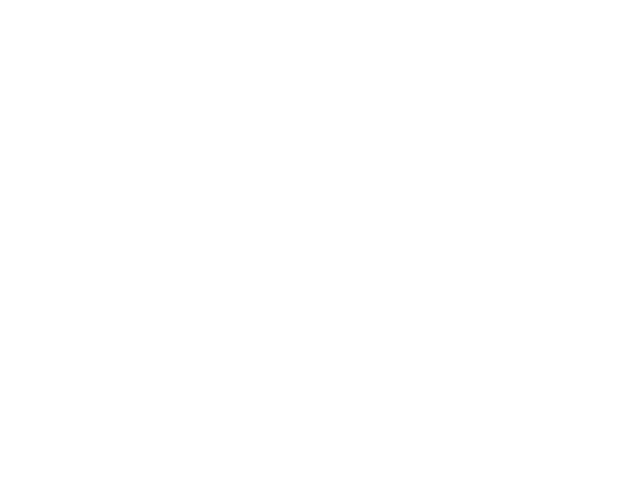

In [7]:
#Plot the evolution of Γ
%matplotlib notebook

# quantity_support()

plt.plot(X, gamma_positron, label = 'Positrons')
plt.plot(X, gamma_electron, label = 'Electrons')
plt.xlabel('$Radius \ (r_{\ell c})$')
plt.ylabel('$\Gamma$')
plt.title('$Lorentz \ Factor$')
plt.legend()
# plt.savefig('ECS_gamma_k2_test.png')

In [8]:
def population(X, k = k, P = Period):
    """
    input : X (radial distance), k (multiplicity), Period (rotational period of the pulsar)
    output : n(X) (number/time/area)
    
    Calculates the flux of particles that enter the ECS at the dimensinless radial position X
    """
    
    n = 2*k/e*np.abs(B_z(X))/P
    
    return n


<IPython.core.display.Javascript object>


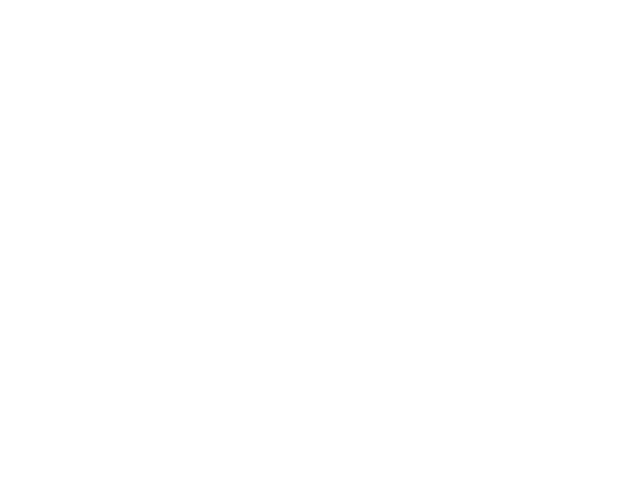

<Quantity [7.64785360e+16, 8.31478296e+16, 8.65319264e+16, 8.83041240e+16,
           8.91154488e+16, 8.92949829e+16, 8.90345428e+16, 8.84564961e+16,
           8.76439049e+16, 8.66557433e+16, 8.55353188e+16, 8.43152699e+16,
           8.30206986e+16, 8.16712224e+16, 8.02823697e+16, 7.88665564e+16,
           7.74337891e+16, 7.59921812e+16, 7.45483407e+16, 7.31076650e+16,
           7.16745689e+16, 7.02526640e+16, 6.88449000e+16, 6.74536785e+16,
           6.60809444e+16, 6.47282610e+16, 6.33968711e+16, 6.20877476e+16,
           6.08016357e+16, 5.95390883e+16, 5.83004950e+16, 5.70861073e+16,
           5.58960599e+16, 5.47303879e+16, 5.35890429e+16, 5.24719053e+16,
           5.13787958e+16, 5.03094849e+16, 4.92637013e+16, 4.82411384e+16,
           4.72414613e+16, 4.62643113e+16, 4.53093107e+16, 4.43760670e+16,
           4.34641758e+16, 4.25732243e+16, 4.17027934e+16, 4.08524599e+16,
           4.00217988e+16, 3.92103846e+16, 3.84177925e+16, 3.76436001e+16,
           3.68873881e+16

In [9]:

plt.figure()
plt.plot(X, population(X))
plt.show()
population(X)

In [10]:
#Define the curvature radiation spectrum of one particle with given R_c and Γ

def curvature_spectrum(nu, nu_crit, R_curv, gamma):
     
    '''
    input : nu (frequency), nu_crit (critical frequency), R_curv (radius of curvature), gamma (lorentz factor)
    output : power(nu) (spectrum)
    The spectrum of curvature radiation from a particle moving with lorentz factor gamma 
    in a curved trajectory of radius R_curv
    '''
    
    integral = sp.integrate.quad(lambda z: kv(5./3., z), nu/nu_crit, +np.inf)[0]*un.dimensionless_unscaled
    
    power = np.sqrt(3)*e**2/(2*np.pi)*gamma/R_curv*nu/nu_crit*integral
    
    return power


In [11]:
#Calculate the spectrum of the particles


#Frequency grid
N_frequency = 100        #Number of frequencies in which the spectrum is calculated
f1 = 20                  #Minimum 
f2 = 30                  #Maximum 
frequency = np.logspace(f1, f2, N_frequency)*un.Hz       #Frequencies distributed evenly in a logarithmic space
photon_energy = (frequency*h).to(un.eV)                  #Corresponding energy in eV


#Critical frequency for curvature radition
nu_crit_positron = 3*c/2*gamma_positron**3/R_curv        
nu_crit_electron = 3*c/2*gamma_electron**3/R_curv        

#Initializing the matrix of the instantaneous spectrum
instant_spec_positron = np.zeros((N_frequency, N_position))*(e.unit**2/R_curv.unit)     
instant_spec_electron = np.zeros((N_frequency, N_position))*(e.unit**2/R_curv.unit)

#Initializing the matrix of the total spectrum
total_spec_positron = np.zeros((N_frequency))*instant_spec_positron.unit
total_spec_electron = np.zeros((N_frequency))*instant_spec_electron.unit

#Spectrum calculation
for nu in range(N_frequency-1):
    for i in range(N_position-1):
        
        #Positrons
        #the instantaneous power emitted by a positron in position X
        instant_spec_positron[nu][i] = curvature_spectrum(frequency[nu], nu_crit_positron[i], R_curv[i], gamma_positron[i])
        #the total powe emitted along the whole trajectory
        total_spec_positron[nu] += instant_spec_positron[nu][i]
        
        #Electrons
        #the instantaneous power emitted by a positron in position X
        instant_spec_electron[nu][i] = curvature_spectrum(frequency[nu], nu_crit_electron[i], R_curv[i], gamma_electron[i])
        #the total powe emitted along the whole trajectory
        total_spec_electron[nu] += instant_spec_electron[nu][i]

/home/petros/anaconda3/lib/python3.7/site-packages/scipy/integrate/quadpack.py:385: IntegrationWarning: The integral is probably divergent, or slowly convergent.
  warnings.warn(msg, IntegrationWarning)
/home/petros/anaconda3/lib/python3.7/site-packages/scipy/integrate/quadpack.py:385: IntegrationWarning: The algorithm does not converge.  Roundoff error is detected
  in the extrapolation table.  It is assumed that the requested tolerance
  cannot be achieved, and that the returned result (if full_output = 1) is 
  the best which can be obtained.
  warnings.warn(msg, IntegrationWarning)


<IPython.core.display.Javascript object>


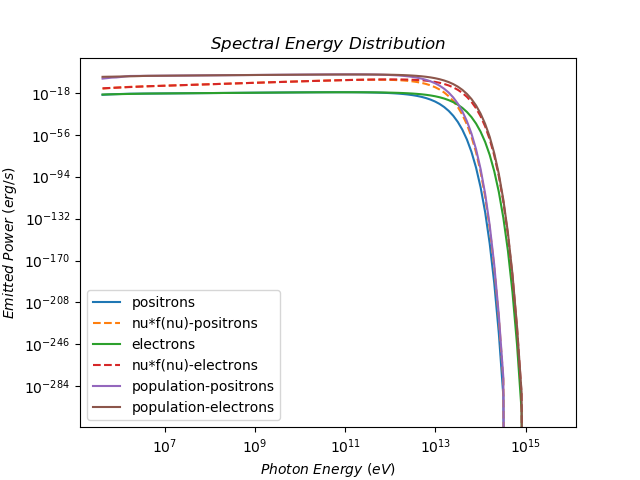

In [14]:
# Spectrum plots
%matplotlib notebook
plt.plot(photon_energy, total_spec_positron, label = 'positrons')
# plt.plot(photon_energy, population(X)*total_spec_positron, label = 'population-positrons')
plt.plot(photon_energy, photon_energy*total_spec_positron, ls = '--', label = 'nu*f(nu)-positrons')
# plt.axvline(photon_energy[index_max_el])

plt.plot(photon_energy, total_spec_electron, label = 'electrons')
# plt.plot(photon_energy, population(X)*total_spec_electron, label = 'population-electrons')
plt.plot(photon_energy, photon_energy*total_spec_electron, ls = '--', label = 'nu*f(nu)-electrons')

total_spec_positron_2 = np.zeros((N_frequency))*instant_spec_positron.unit*population(X[i]).unit
total_spec_electron_2 = np.zeros((N_frequency))*instant_spec_electron.unit*population(X[i]).unit

for i in range(N_position):
        total_spec_positron_2 += instant_spec_positron[:, i]*population(X[i])/2
        total_spec_electron_2 += instant_spec_electron[:, i]*population(X[i])/2

#     plt.plot(photon_energy, instant_spec_positron[:, i])
        
plt.plot(photon_energy, total_spec_positron_2, label = 'population-positrons')
plt.plot(photon_energy, total_spec_electron_2, label = 'population-electrons')

plt.xscale('log')
plt.yscale('log')
# plt.ylim([10**(-24),10**(-5)])
# plt.xlim([10**(7),10**(13)])
plt.xlabel('$Photon \ Energy \ (eV)$')
plt.ylabel('$Emitted \ Power \ (erg/s)$')
plt.title('$Spectral \ Energy \ Distribution$')
plt.legend()
# plt.savefig('ECS_spectrum_k2_test.png')

In [13]:
def population2(a):
    pop = (4*np.pi*k*r_lc**2)/e * sp.integrate.quad(lambda y: B_z(y).value*y, x1, a*un.dimensionless_unscaled)[0]*un.G
    return pop
test = np.zeros([N_position])
for i in range(N_position):
    test[i] = population2(X[i])
    
test    

TypeError: only dimensionless scalar quantities can be converted to Python scalars

In [ ]:
B_z(X)

In [ ]:
sp.integrate.quad(lambda y: B_z(y).value*y, x1, x2)[0]*un.G